In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
import pymc as pm

sys.path.append("..")
from src.utils import *
from scipy.stats import ttest_ind, permutation_test
from scipy import stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# polars config
pl.Config.load_from_file("../polars_cfg.json")

In [3]:
# load / process data
df_summary = pl.read_csv("../../arc_project/data/clean_summary_data_merged.csv")
df_incomplete = pl.read_csv("../../arc_project/data/clean_incomplete_data_merged.csv")
_, df_incomplete_summary = include_incomplete(df_summary, df_incomplete)

# load task acc
mean_task_acc_one_attempt = pl.read_csv("../data/mean_task_acc_one_attempts.csv")
mean_task_acc_two_attempts = pl.read_csv("../data/mean_task_acc_two_attempts.csv")
mean_task_acc_three_attempts = pl.read_csv("../data/mean_task_acc_three_attempts.csv")

Filtered out 59/783 incomplete participant task attempts


In [4]:
def sample_tasks(
    hashed_id, completed_tasks, task_type="training", shots=3, type="mean"
):
    if shots == 3:
        tasks = mean_task_acc_three_attempts
    elif shots == 2:
        tasks = mean_task_acc_two_attempts
    elif shots == 1:
        tasks = mean_task_acc_one_attempt
    else:
        raise ValueError(f"Shots must be 1, 2, or 3, got {shots}")
    tasks = tasks.filter(
        (pl.col("task_type") == task_type) & ~pl.col("task_name").is_in(completed_tasks)
    )
    tasks = tasks.sample(n=5 - len(completed_tasks))
    # sample from binomial with p = mean_solved for each task
    if type == "mean":
        func = lambda x: np.random.binomial(1, x)
    elif type == "floor":
        func = lambda x: 0
    elif type == "ceiling":
        func = lambda x: 1
    tasks = tasks.with_columns(
        pl.col("mean_solved")
        .map_elements(func, return_dtype=pl.Int32)
        .alias("solved")
        .cast(pl.Boolean)
    )
    tasks = tasks.with_columns(pl.lit(hashed_id).alias("hashed_id"))
    return tasks

In [7]:
# simulate range of possible performance values
def simulate_performance(
    df_summary, df_incomplete_summary, shots, task_type, n_samples=1000, type="mean"
):
    # list to store performance estimates
    performance_estimates = []
    # columns to keep
    columns = [
        "hashed_id",
        "task_name",
        "solved",
        "task_type",
    ]
    df_summary = (
        df_summary.filter(
            (pl.col("attempt_number") <= shots) & (pl.col("task_type") == task_type)
        )
        .group_by("joint_id_task")
        .agg(
            pl.col("solved").any(),
            pl.first("task_name"),
            pl.first("task_type"),
            pl.first("hashed_id"),
        )
    ).select(columns)

    df_incomplete_summary = (
        df_incomplete_summary.filter(
            (pl.col("attempt_number") <= shots) & (pl.col("task_type") == task_type)
        )
        .group_by("joint_id_task")
        .agg(
            pl.col("solved").any(),
            pl.first("task_name"),
            pl.first("task_type"),
            pl.first("hashed_id"),
        )
    ).select(columns)

    # get unique hashed_ids for incomplete participants
    hashed_ids = (
        df_incomplete_summary.unique(subset=["hashed_id"])
        .select(pl.col("hashed_id"))
        .to_series()
        .to_list()
    )
    for _ in range(n_samples):
        df_summary_augmented = df_summary.clone()
        for hashed_id in hashed_ids:
            completed_tasks = (
                df_incomplete_summary.filter((pl.col("hashed_id") == hashed_id))
                .unique(subset=["task_name"])
                .select(pl.col("task_name"))
                .to_series()
                .to_list()
            )
            sample = sample_tasks(
                hashed_id, completed_tasks, task_type=task_type, shots=shots, type=type
            )
            sample = sample.select(columns)
            p_data = df_incomplete_summary.filter(pl.col("hashed_id") == hashed_id)
            p_data = p_data.vstack(sample)
            df_summary_augmented = df_summary_augmented.vstack(p_data)
        performance_estimates.append(
            df_summary_augmented.group_by("task_name")
            .agg(pl.col("solved").mean().alias("mean_solved"))
            .select(pl.mean("mean_solved"))
            .item()
        )
    return performance_estimates

In [11]:
task_types = ["training", "evaluation"]
shots = [1, 2, 3]
performance_dfs = []
type_samples = [("mean", 500), ("floor", 500), ("ceiling", 500)]
for type, n_samples in type_samples:
    performance_df = {
        "estimates": [],
        "shots": [],
        "task_type": [],
        "type": [],
    }
    for task_type in task_types:
        for shot in shots:
            simulated_performance = simulate_performance(
                df_summary,
                df_incomplete_summary,
                shots=shot,
                task_type=task_type,
                n_samples=n_samples,
                type=type,
            )
            performance_df["estimates"].extend(simulated_performance)
            performance_df["shots"].extend([shot] * n_samples)
            performance_df["task_type"].extend([task_type] * n_samples)
            performance_df["type"].extend([type] * n_samples)
    performance_df = pl.DataFrame(performance_df)
    performance_dfs.append(performance_df)

In [12]:
performance_df = pl.concat(performance_dfs)
performance_df.write_csv("../../arc_project/data/simulated_performance_estimates.csv")
performance_df.head()

estimates,shots,task_type,type
f64,i64,str,str
0.598784,1,"""training""","""mean"""
0.5974,1,"""training""","""mean"""
0.60067,1,"""training""","""mean"""
0.599062,1,"""training""","""mean"""
0.600927,1,"""training""","""mean"""


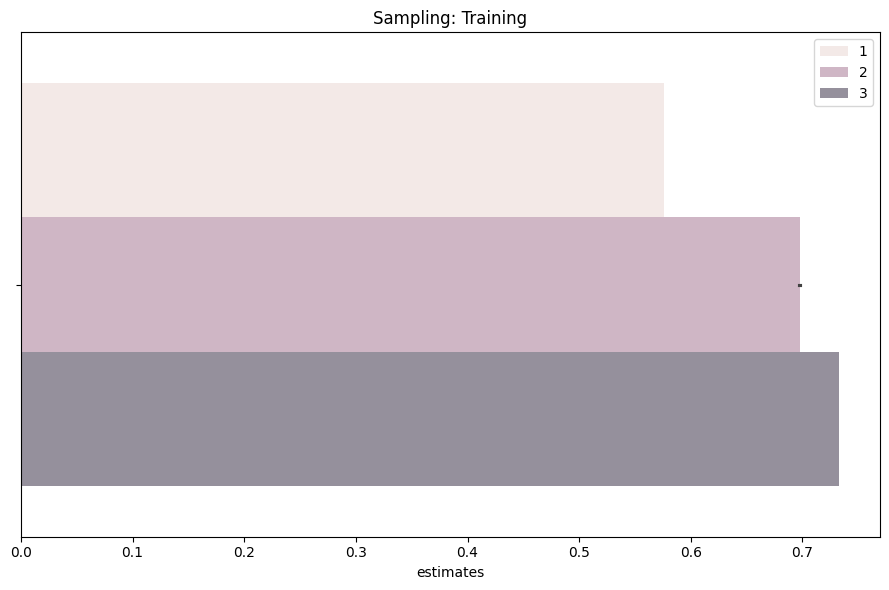

In [31]:
fig, axs = plt.subplots(figsize=(9, 6))
filtered_df = performance_df.filter(
    (pl.col("task_type") == "training") & (pl.col("type") == "floor")
)
sns.barplot(
    filtered_df,
    x="estimates",
    hue="shots",
    alpha=0.5,
    ax=axs,
    errorbar="ci",
)
# # add credible interval
# plt.axvline(np.percentile(one_shot_training.get_column("estimates"), 2.5), color="red")
# plt.axvline(np.percentile(one_shot_training.get_column("estimates"), 97.5), color="red")
axs.legend()
axs.set_title(f"Sampling: Training")
plt.tight_layout()
plt.show()

In [38]:
# print mean, std and credible interval for 1,2,3 shots for training and evaluation
for task_type in task_types:
    for shot in [1, 2, 3]:
        performance_df_filtered = performance_df.filter(
            (pl.col("shots") == shot) & (pl.col("task_type") == task_type)
        )
        print(f"Task Type: {task_type}, Shots: {shot}")
        print("-" * 50)
        mean_floor = (
            performance_df_filtered.filter(pl.col("type") == "floor")
            .select(pl.mean("estimates"))
            .item()
        )
        mean_ceiling = (
            performance_df_filtered.filter(pl.col("type") == "ceiling")
            .select(pl.mean("estimates"))
            .item()
        )
        print(f"Mean Floor: {round(mean_floor, 3)}")
        print(f"Mean Ceiling: {round(mean_ceiling, 3)}")
        std_floor = (
            performance_df_filtered.filter(pl.col("type") == "floor")
            .select(pl.std("estimates"))
            .item()
        )
        std_ceiling = (
            performance_df_filtered.filter(pl.col("type") == "ceiling")
            .select(pl.std("estimates"))
            .item()
        )
        print(f"Std Floor: {round(std_floor, 3)}")
        print(f"Std Ceiling: {round(std_ceiling, 3)}")
        print(
            f"95% Confidence Interval Floor: {round(mean_floor - 1.96 * std_floor, 3)} to {round(mean_floor + 1.96 * std_floor, 3)}"
        )
        print(
            f"95% Confidence Interval Ceiling: {round(mean_ceiling - 1.96 * std_ceiling, 3)} to {round(mean_ceiling + 1.96 * std_ceiling, 3)}"
        )
        print("-" * 50)

Task Type: training, Shots: 1
--------------------------------------------------
Mean Floor: 0.576
Mean Ceiling: 0.615
Std Floor: 0.001
Std Ceiling: 0.001
95% Confidence Interval Floor: 0.574 to 0.578
95% Confidence Interval Ceiling: 0.613 to 0.617
--------------------------------------------------
Task Type: training, Shots: 2
--------------------------------------------------
Mean Floor: 0.697
Mean Ceiling: 0.737
Std Floor: 0.001
Std Ceiling: 0.001
95% Confidence Interval Floor: 0.695 to 0.7
95% Confidence Interval Ceiling: 0.735 to 0.739
--------------------------------------------------
Task Type: training, Shots: 3
--------------------------------------------------
Mean Floor: 0.733
Mean Ceiling: 0.772
Std Floor: 0.001
Std Ceiling: 0.001
95% Confidence Interval Floor: 0.73 to 0.735
95% Confidence Interval Ceiling: 0.77 to 0.774
--------------------------------------------------
Task Type: evaluation, Shots: 1
--------------------------------------------------
Mean Floor: 0.416
Mea

In [ ]:
# Use the new function
trace, participants, tasks = simulate_performance_with_irt(
    df_summary, df_incomplete_summary, shots=3, task_type="training"
)

# Analyze results
pm.plot_posterior(trace)
plt.show()

# Print summary statistics
print(pm.summary(trace, var_names=["mu_alpha", "sigma_alpha", "mu_beta", "sigma_beta"]))

# Plot ability and difficulty distributions
ability_means = trace["alpha"].mean(axis=0)
difficulty_means = trace["beta"].mean(axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ability_means, bins=20)
plt.title("Distribution of Participant Abilities")
plt.xlabel("Ability (alpha)")

plt.subplot(1, 2, 2)
plt.hist(difficulty_means, bins=20)
plt.title("Distribution of Task Difficulties")
plt.xlabel("Difficulty (beta)")

plt.tight_layout()
plt.show()

# Print top 5 easiest and hardest tasks
task_difficulties = pd.DataFrame({"task": tasks, "difficulty": difficulty_means})
print("Top 5 Easiest Tasks:")
print(task_difficulties.sort_values("difficulty").head())
print("\nTop 5 Hardest Tasks:")
print(task_difficulties.sort_values("difficulty", ascending=False).head())